In [388]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [817]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [832]:
# run this ceil for different data sets

α = [1.0, -2.0] # single index for x
θ = [2.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 2000
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 0 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5
intercept = 0
# Estimation 

model1 = qgplsim.model(X, Z, y, τ, intercept)
alpha_type = 1

# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta, squ = qgplsim.estimator(model1, alpha_type)

println("Estimation of index coefs: ")
println("̂α => ", alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

println("square of integral: ", squ)

# theta * alpha

  5.273125 seconds (19.54 M allocations: 9.929 GiB, 39.96% gc time)
Estimation of index coefs: 
̂α => [0.451447819819021; -0.8922975209988273]
̂γ => [0.1273340664798533, 0.23417617277813516]
Estimation of linear coefs: 
̂θ => [1.9941837895364172 1.0089346915330408]
̂β => [-0.2946130426390234, -0.046740716452757396]
square of integral: 10.800099236980689


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

width = 0.8452701500201184
dy = 1.9611545968774449


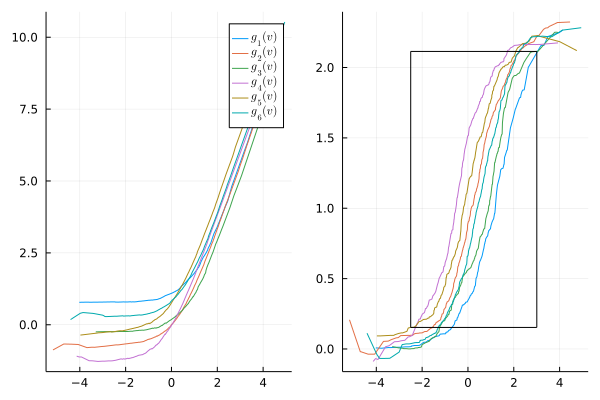

In [833]:
g = zeros(n)
dg = zeros(n)
v = X * alpha1 
yz = y - X * transpose(theta)
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h
    vkmax = maximum(vk) - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println("width = ", mean(width))
# v0, v1 = v0 + h, v1 - h
# v0, v1

v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)
# _v, v_

C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
println("dy = ", c1 - c0)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

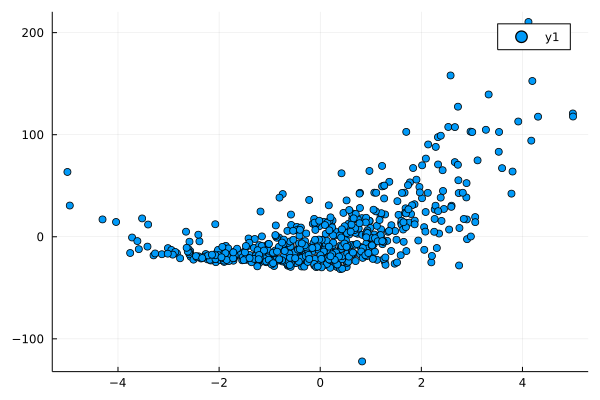

In [308]:
scatter(X[:,2], y)

# Monte Carlo Simulation

In [621]:
Threads.nthreads()

2

In [797]:
include("MonteCarloSIM.ji")

α = [1.0, -2.0] # single index for x
θ = [2.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n =250
fx = 1
dist = 0 # Cauchy
rep = 100 # MC rept. times

100

In [798]:
Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

([0.4445488134368807 -0.8957546273795417; 0.4664495508527998 -0.8845478034053452; … ; 0.41989228881250046 -0.9075739450842558; 0.437303525290908 -0.8993139756326175], [0.04694442132536195 0.6183727940562217; 0.22147331248993773 0.7026545050391594; … ; 0.4156238540256849 0.4105087645266307; 0.1342703033279708 0.6528992869685828], [1.8474423055254192 0.9168563127795433; 1.850871949711134 0.9760223091449807; … ; 2.4717812012753684 1.143578296477952; 2.211983375179104 1.0756066891657696], [-3.35222768632555 -1.5294828785374868; -0.7284693490517657 -0.9935778254561939; … ; 1.350747856810302 0.5554048138432676; 0.4834681111537456 1.1504898024240593], [7.876340725036563, 0.5107440445834925, -7.104572580134861, 8.252272749638419, 7.993938604481862, 2.7665290805042297, 19.487078660303563, 5.977158818708615, 2.008759219196035, 28.61856515153219  …  6.147465993476723, 0.45876842599001405, 16.592141488747956, 5.526134206426448, -1.79657890946189, 32.7304929654847, -1.8655036438336954, -7.517789010

In [799]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 -0.134137  -0.408218

In [800]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.445921  -0.89491

In [801]:
mg = mean(Gamma, dims = 1) 

1×2 Matrix{Float64}:
 0.311892  0.642621

In [718]:
(1 ./ma[1]) * mg 

1×2 Matrix{Float64}:
 0.596276  0.394768

In [710]:
norm(α)/norm(γ)

1.2403473458920846

In [709]:
norm(ma)/norm(mg)

1.5638379812255894

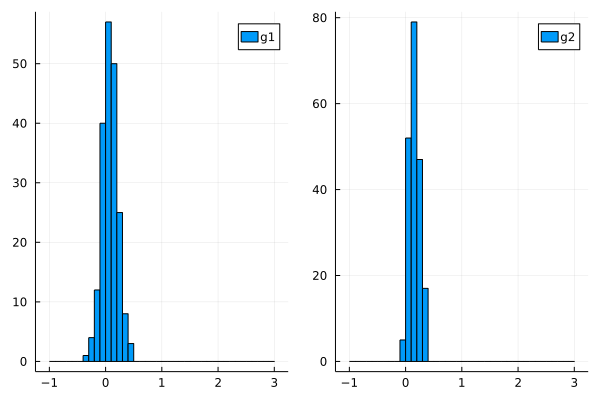

In [125]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [127]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 2.0041  0.961145

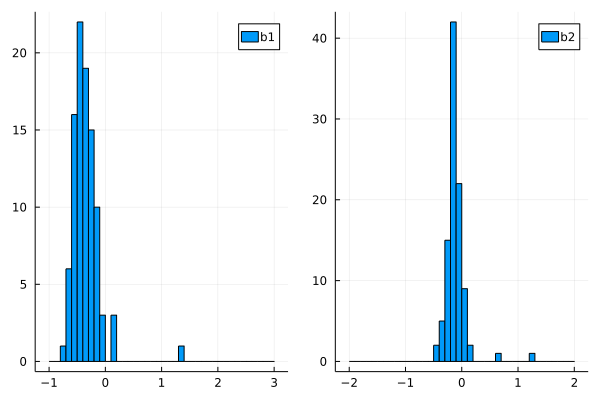

In [81]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

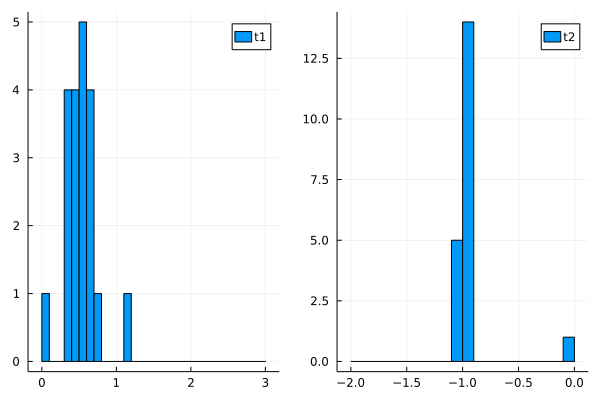

In [91]:
p1 = histogram(Theta[:,1], bins = 0:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

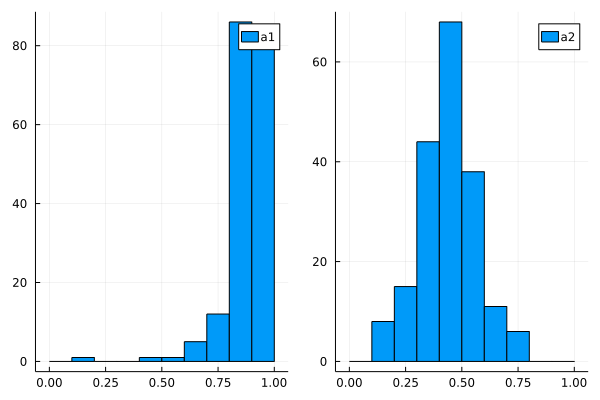

In [35]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))